# Exploratory Data Analysis: What is the Toughest Sport?

## Abstract

Determining the "**toughest**" sport is a complex task, as different sports require varying combinations of athletic skills. This exploratory data analysis examines a dataset from [ESPN](link) ranking sports based on key attributes such as *endurance*, *strength*, *power*, *speed*, *agility*, *flexibility*, *nerve*, *durability*, *hand-eye coordination*, and *analytical aptitude*.

We will explore:

1. **Which sports are easiest and toughest for each athletic skill?**

2. **Which athletic skills are most predictive of a sport's overall toughness?**

3. **Do sports naturally cluster into distinct athletic profile categories?**

4. **Which sports require specialization versus being well-rounded across multiple skills?**

5. **What are the co-dependency patterns among athletic skills across different sports?**
---
## Dataset Overview

The dataset contains comprehensive skill ratings for various sports, with each sport evaluated across ten key athletic dimensions by a panel of experts. These ratings form the foundation for understanding the multifaceted nature of athletic demands across different sporting disciplines.

---
## Athletic Skill Definitions

|Skill                   | Definition                                      | Exemplar Athlete       |
|-------------------------|------------------------------------------------|------------------------|
| **Endurance**           | Sustained performance capacity                 | Tadej Pogačar/Eliud Kipchoge        |
| **Strength**            | Force production                               | Eddie Hall/Teddy Rinner        |
| **Power**               | Explosive strength                             | Mike Tyson/Serena Williams            |
| **Speed**               | Rapid movement                                 | Usain Bolt/Tyreek Hill           |
| **Agility**            | Direction-change ability                       | Lionel Messi/Kyrie Irving               |
| **Flexibility**        | Joint range of motion                          | Nadia Comăneci/Tom Daley                |
| **Nerve**              | Fear resilience                                | Alex Honnold/Matti Nykänen            |
| **Durability**         | Physical punishment tolerance                  | Brett Favre/George Foreman            |
| **Hand-eye Coordination** | Sensory-motor reaction                        | Steph Curry/Ichiro Suzuki       |
| **Analytical Aptitude** | Strategic decision-making                      | Xavi Hernández/John Stockton       |

## Technical Setup


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from math import pi
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import plotly.express as px
import networkx as nx
from networkx.algorithms import community
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.stats import f_oneway
from IPython.display import display, Markdown

plt.style.use('default')

## Data Loading, Initial Inspection and *Visualization*

In [2]:
df = pd.read_excel('toughest_sport.xlsx')
df.head()

,Sport,Endurance,Strength,Power,Speed,Agility,Flexibility,Nerve,Durability,Hand-Eye Coordination,Analytical Aptitude,Total,Rank
0,Boxing,8.63,8.13,8.63,6.38,6.25,4.38,8.88,8.50,7.00,5.63,72.375,1
1,Ice Hockey,7.25,7.13,7.88,7.75,7.63,4.88,6.00,8.25,7.50,7.50,71.750,2
2,Football,5.38,8.63,8.13,7.13,6.38,4.38,7.25,8.50,5.50,7.13,68.375,3
3,Basketball,7.38,6.25,6.50,7.25,8.13,5.63,4.13,7.75,7.50,7.38,67.875,4
4,Wrestling,6.63,8.38,7.13,5.13,6.38,7.50,5.00,6.75,4.25,6.38,63.500,5


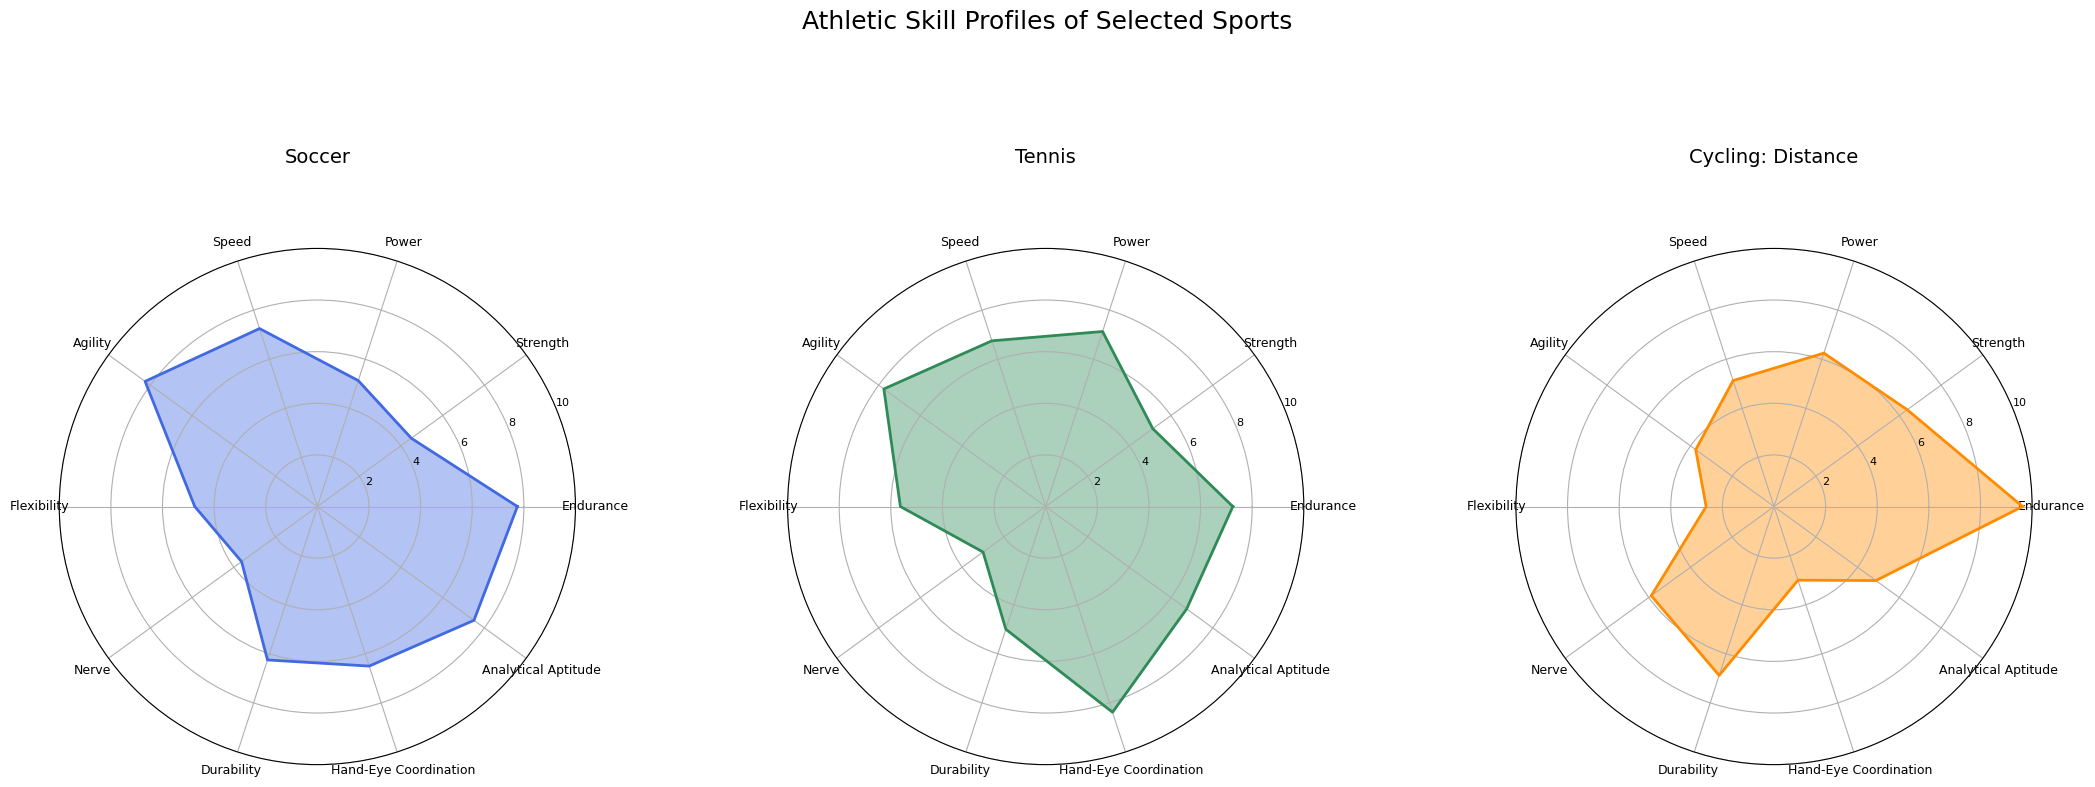

In [3]:
skills = ['Endurance', 'Strength', 'Power', 'Speed', 'Agility',
              'Flexibility', 'Nerve', 'Durability', 'Hand-Eye Coordination', 'Analytical Aptitude']

def plot_radar(ax, sport_name, df, color='skyblue'):

    values = df[df['Sport'] == sport_name][skills].values.flatten().tolist()
    values += values[:1]

    angles = [n / float(len(skills)) * 2 * pi for n in range(len(skills))]
    angles += angles[:1]

    ax.plot(angles, values, linewidth=2, linestyle='solid', color=color)
    ax.fill(angles, values, alpha=0.4, color=color)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(skills, fontsize=9)

    ax.set_yticks([2, 4, 6, 8, 10])  # control the levels shown
    ax.set_yticklabels(['2', '4', '6', '8', '10'], fontsize=8)
    ax.set_ylim(0, 10)

    ax.set_title(f'{sport_name}', fontsize=14, y=1.15)

fig, axes = plt.subplots(1, 3, figsize=(22, 7), subplot_kw=dict(polar=True))
fig.suptitle('Athletic Skill Profiles of Selected Sports', fontsize=18, y=1.1)

plot_radar(axes[0], 'Soccer', df, color='royalblue')
plot_radar(axes[1], 'Tennis', df, color='seagreen')
plot_radar(axes[2], 'Cycling: Distance', df, color='darkorange')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

The radar charts help us visualize distinct athletic demands across sports. **Soccer** involves agility and analytical aptitude, reflecting its spatial complexity. **Tennis** shows a more balanced distribution. In contrast, **Cycling: Distance** heavily leans on endurance and durability, highlighting the physiological intensity of sustained aerobic output.

<Figure size 1400x1200 with 0 Axes>

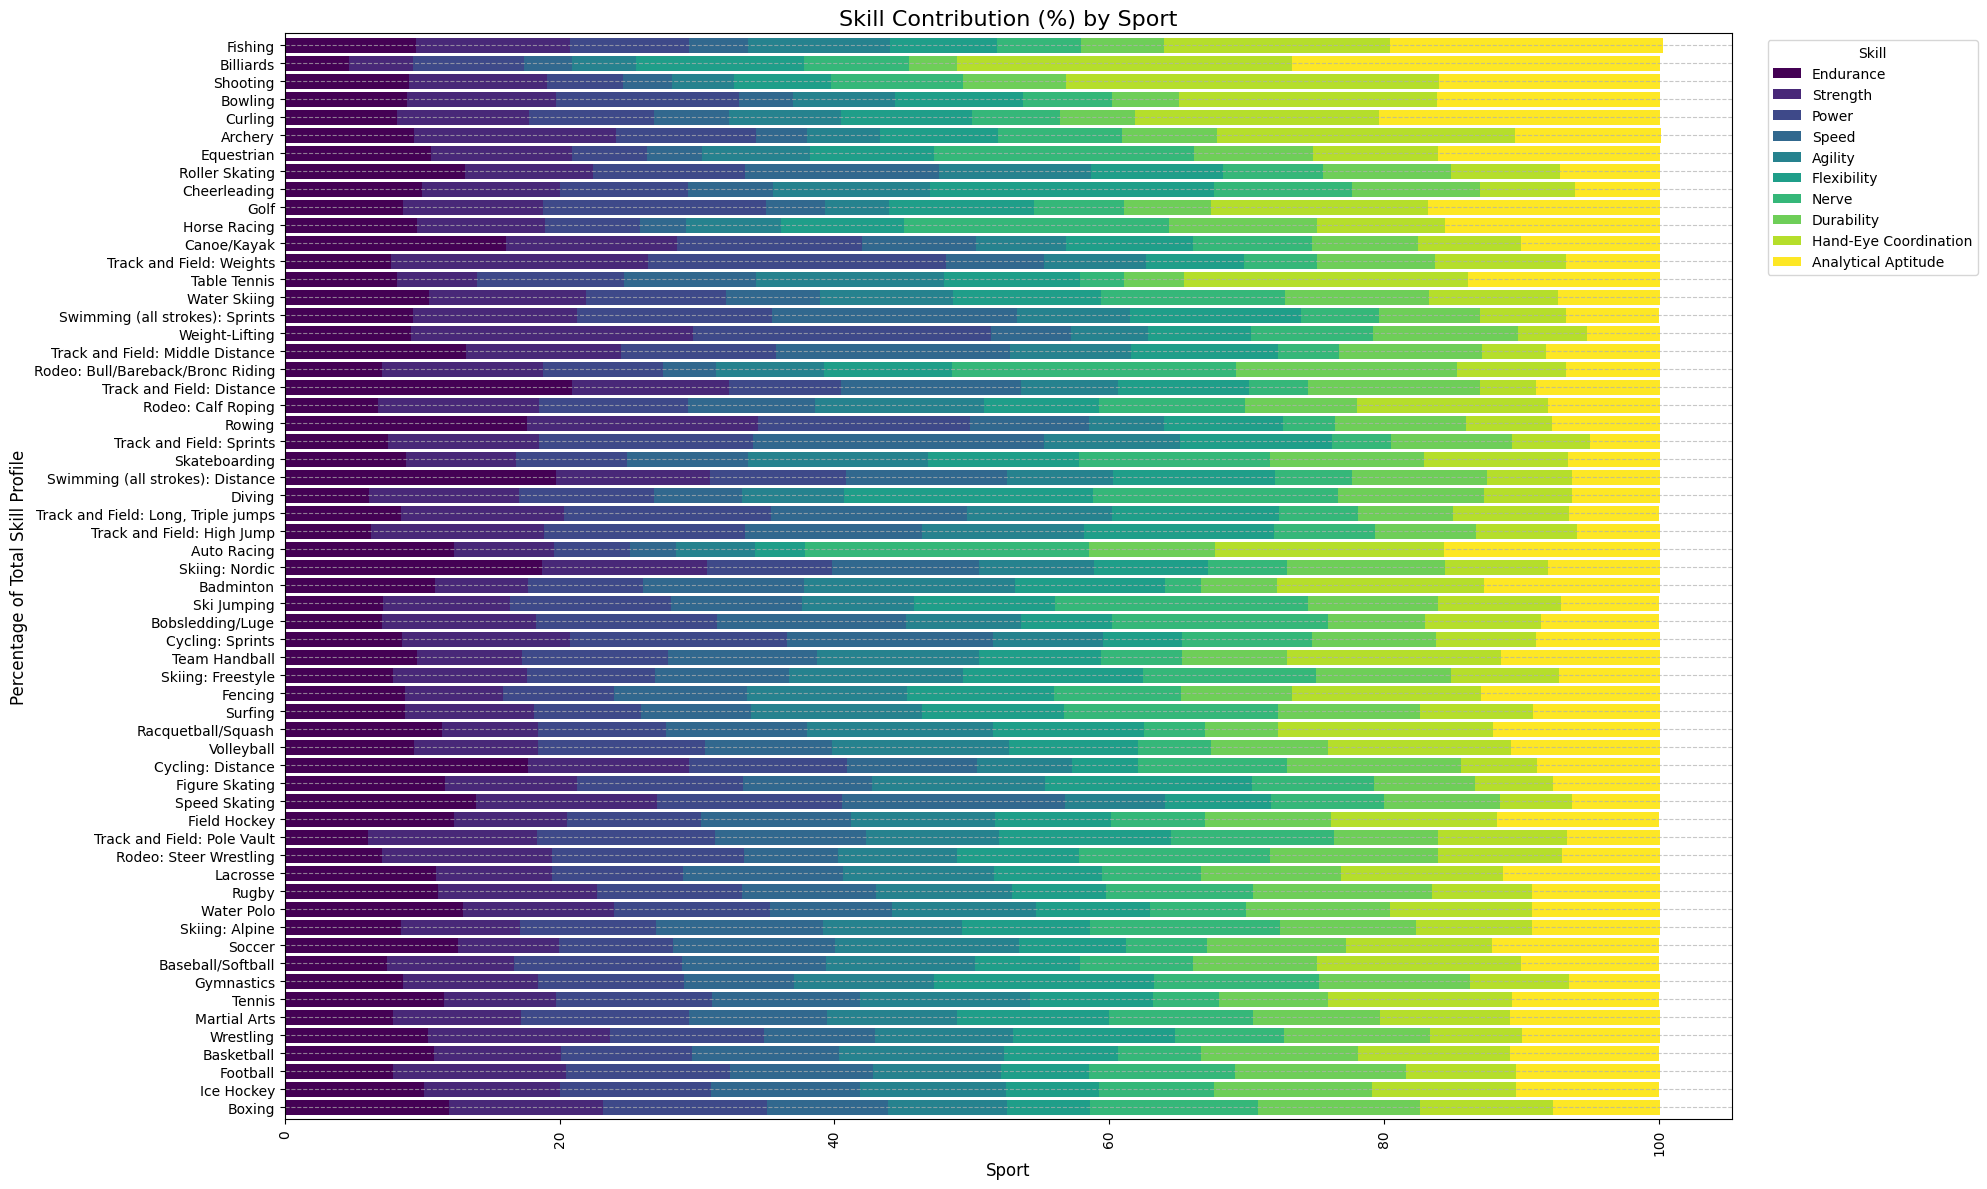

In [4]:
df_normalized = df.copy()
for skill in skills:
    df_normalized[skill] = (df[skill] / df['Total']) * 100

plt.figure(figsize=(14, 12))
df_sorted = df_normalized.sort_values('Total', ascending=False)
df_sorted.set_index('Sport')[skills].plot(
    kind='barh', stacked=True, colormap='viridis', width=0.85, figsize=(20, 12)
)

plt.title('Skill Contribution (%) by Sport', fontsize=16)
plt.xlabel('Sport', fontsize=12)
plt.ylabel('Percentage of Total Skill Profile', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.legend(title='Skill', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

This stacked bar chart illustrates how each sport's overall difficulty is distributed across the ten athletic skills. While sports like **Boxing** and **Wrestling** are heavily skewed toward strength, endurance, and power, others like **Fencing** or **Golf** rely more on hand-eye coordination and analytical aptitude. Interestingly, the relative proportions reveal that even sports with similar total difficulty can demand very different skill combinations — highlighting the qualitative diversity in athletic challenges across disciplines. This visualization reframes difficulty not just as a matter of how much, but what kind of ability is required.

## 1. **Which Sports are Easiest and Toughest for Each Athletic Skill?**

---

The clustermap analysis reveals the extreme ends of each skill requirement across different sports, identifying which sports demand the most and least of each athletic ability.

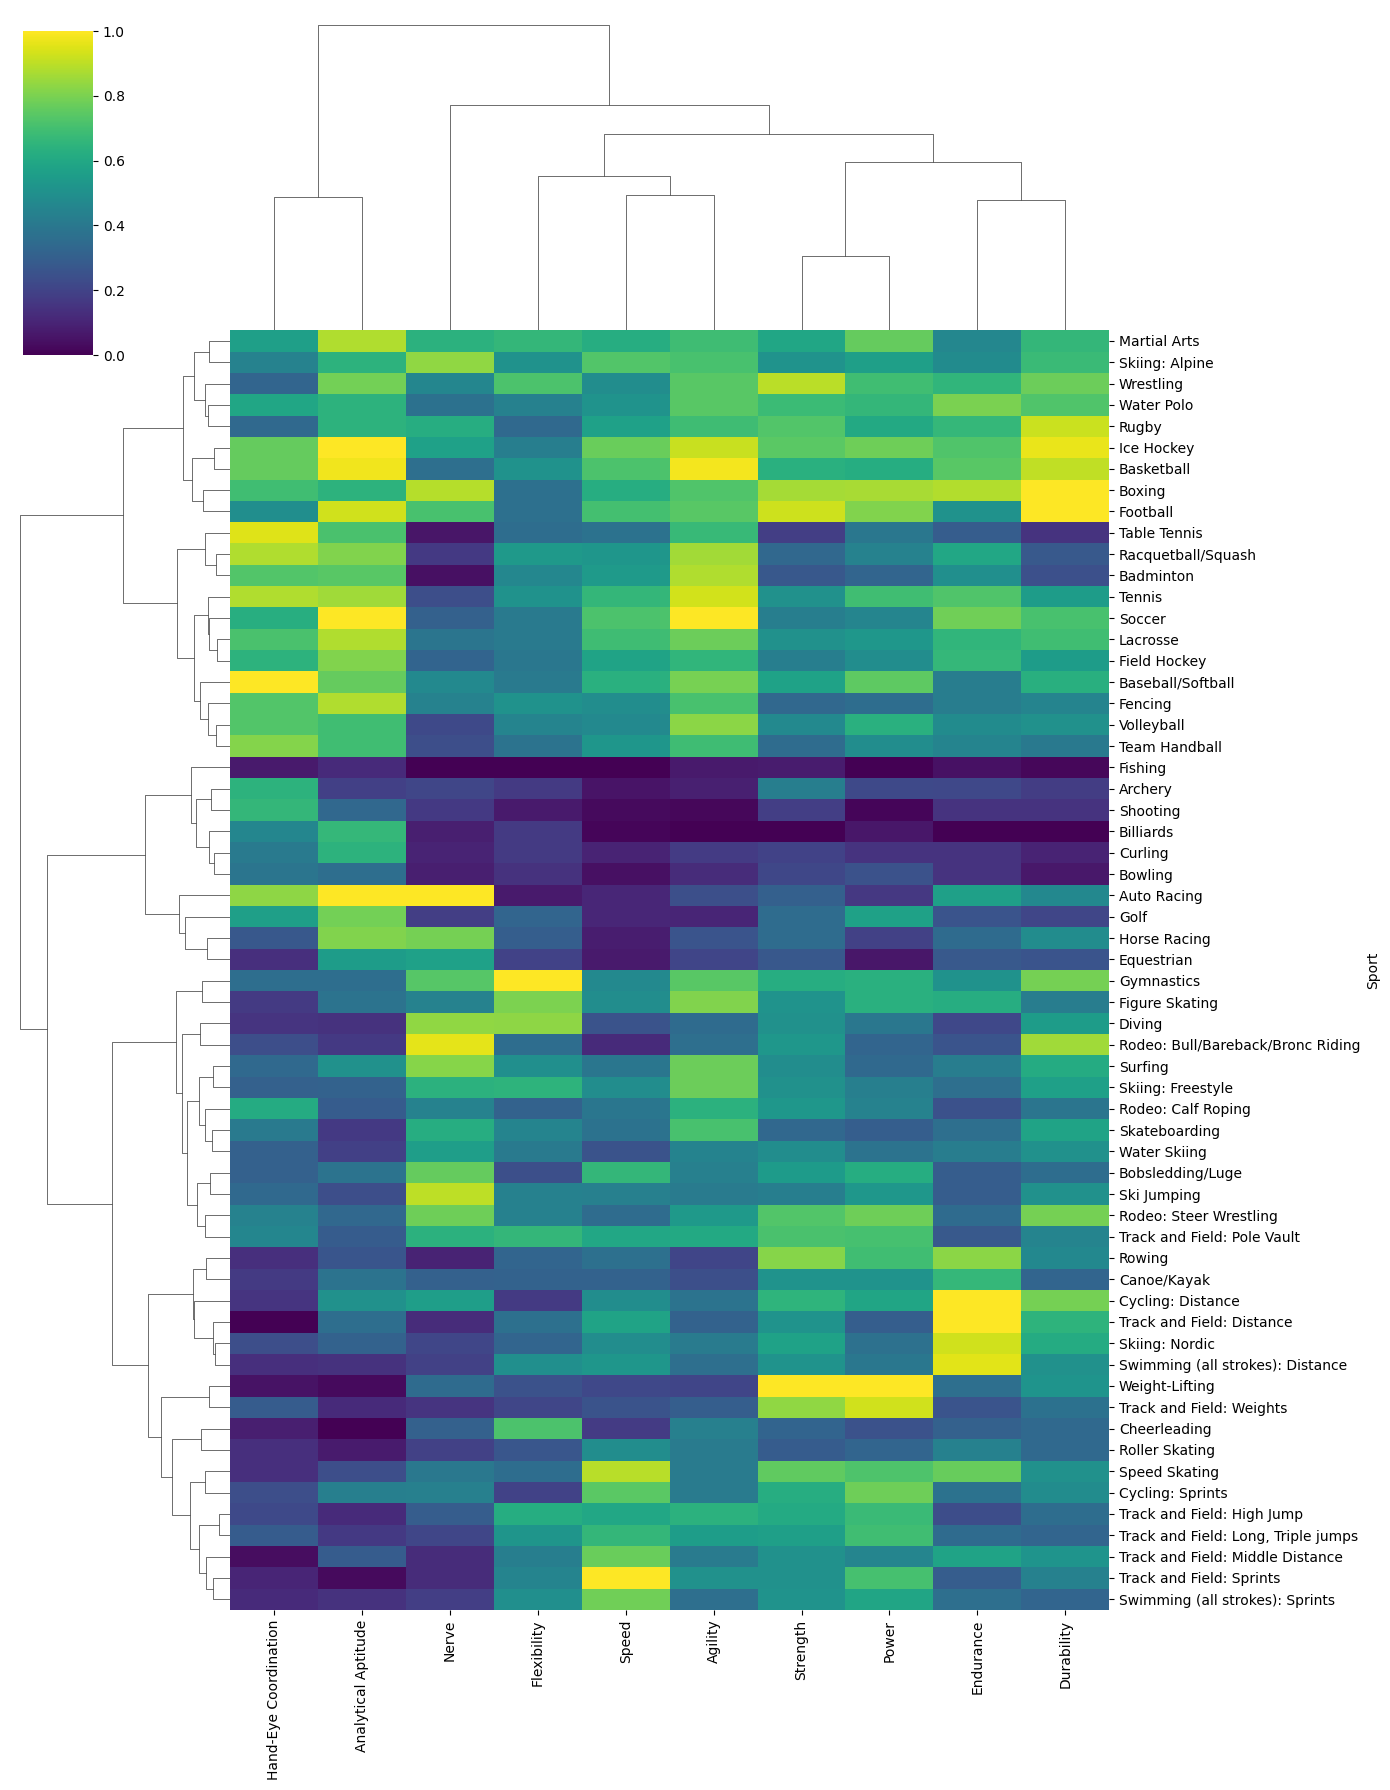

In [5]:
sns.clustermap(
    df.set_index("Sport")[skills],
    method='ward',
    cmap="viridis",
    figsize=(14, 18),
    standard_scale=1
)

In [6]:
skill_extremes = {}
for skill in skills:
    max_sport = df.loc[df[skill].idxmax(), 'Sport']
    min_sport = df.loc[df[skill].idxmin(), 'Sport']
    skill_extremes[skill] = {'Max': max_sport, 'Min': min_sport,
                            'Max_Value': df[skill].max(),
                            'Min_Value': df[skill].min()}

skill_summary = pd.DataFrame(skill_extremes).T.reset_index()
skill_summary.columns = ['Skill', 'Max Sport', 'Min Sport', 'Max Value', 'Min Value']

skill_summary = skill_summary.sort_values('Skill').reset_index(drop=True)

skill_summary

,Skill,Max Sport,Min Sport,Max Value,Min Value
0,Agility,Soccer,Billiards,8.25,1.0
1,Analytical Aptitude,Ice Hockey,Cheerleading,7.5,2.25
2,Durability,Boxing,Billiards,8.5,0.75
3,Endurance,Cycling: Distance,Billiards,9.63,1.0
4,Flexibility,Gymnastics,Fishing,10.0,1.13
5,Hand-Eye Coordination,Baseball/Softball,Track and Field: Distance,9.25,1.88
6,Nerve,Auto Racing,Fishing,9.88,0.88
7,Power,Weight-Lifting,Fishing,9.75,1.25
8,Speed,Track and Field: Sprints,Fishing,9.88,0.63
9,Strength,Weight-Lifting,Billiards,9.25,1.0


Table 1 highlights the range of specialization across different athletic skills. Each row identifies the sport with the highest and lowest rating for a given skill, along with the corresponding values. For example, **Gymnastics** achieves a perfect score in Flexibility (10.0), while **Fishing** consistently appears at the bottom for multiple physical dimensions — including Power, Speed, and Nerve — underscoring its relatively low physical demand. In contrast, **Boxing**, **Ice Hockey**, and **Weight-Lifting** dominate in strength-intensive or high-pressure categories. This comparison reveals not just which sports are the "hardest" overall, but which ones push specific dimensions of human ability to their extremes.

## 2. **Which Athletic Skills are Most Predictive of a Sport's Overall Toughness?**


---


These scores show how much each skill contributes to predicting a sport's total difficulty score. Higher numbers = more important for determining if a sport is tough or easy.

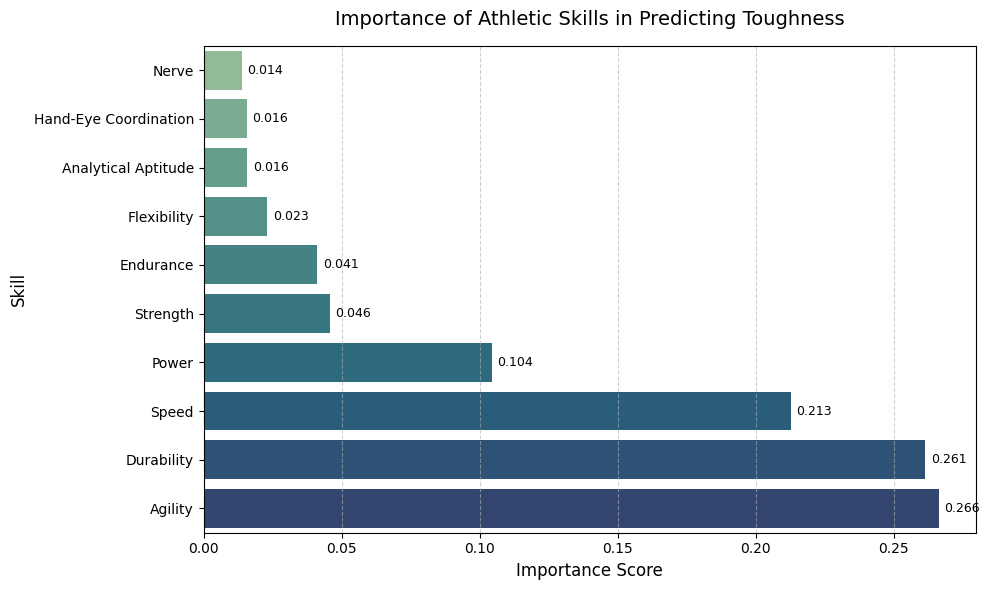

In [7]:
X = df[skills]
y = df['Total']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=skills).sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(
    x=importances.values,
    y=importances.index,
    hue=importances.index,
    palette='crest',
    dodge=False,
    legend=False
)

for i, v in enumerate(importances.values):
    plt.text(v + 0.002, i, f'{v:.3f}', color='black', va='center', fontsize=9)

plt.title('Importance of Athletic Skills in Predicting Toughness', fontsize=14, pad=15)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Skill', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [8]:
print("Feature Importance Scores:")
print(importances)

Feature Importance Scores:
Nerve                    0.013803
Hand-Eye Coordination    0.015547
Analytical Aptitude      0.015752
Flexibility              0.023077
Endurance                0.041105
Strength                 0.045754
Power                    0.104420
Speed                    0.212751
Durability               0.261437
Agility                  0.266354
dtype: float64


If you could only look at a few skills to guess how tough a sport is, which ones should you focus on? This chart answers that question using a Random Forest Regressor, which models how each skill contributes to the overall "toughness" score of a sport. The higher the importance score, the more influential that skill is in predicting how tough a sport will be. It shows that sports requiring high levels of Agility and Durability are more likely to be rated as tough overall. In contrast, Flexibility or Hand-Eye Coordination may vary more independently of overall difficulty.

It’s like turning the question "What makes a sport tough?" into a machine learning problem—and letting the data speak.

## 3. **Do Sports Naturally Cluster into Distinct Athletic Profile Categories?**


---


This analysis investigates whether sports can be systematically grouped into meaningful clusters based on their athletic skill requirements. Using hierarchical clustering methods, the study examines if sports with similar skill profiles naturally form distinct categories (such as combat sports, endurance sports, or precision-based sports) and explores the defining characteristics of each cluster.

=== Cluster Optimization Analysis ===


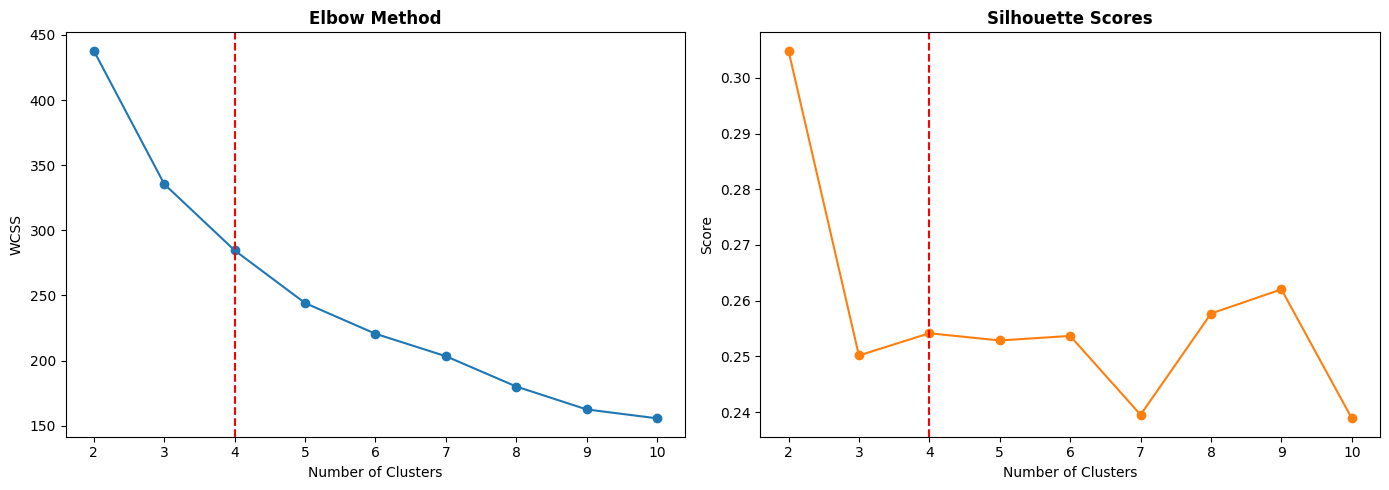


Cluster Validation Metrics (k=4):
- Silhouette Score: 0.254
- Davies-Bouldin Index: 1.386

PCA Explained Variance Ratio: [0.418 0.197 0.117]

=== ANOVA Results for Cluster Differences ===
Endurance                 F =  15.69, p = 0.0000
Strength                  F =  13.45, p = 0.0000
Power                     F =  15.19, p = 0.0000
Speed                     F =  29.47, p = 0.0000
Agility                   F =  54.72, p = 0.0000
Flexibility               F =  17.37, p = 0.0000
Nerve                     F =   9.18, p = 0.0000
Durability                F =  16.19, p = 0.0000
Hand-Eye Coordination     F =  27.59, p = 0.0000
Analytical Aptitude       F =  44.13, p = 0.0000


In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[skills])

print("=== Cluster Optimization Analysis ===")
wcss = []
silhouette_scores = []
k_range = range(2, 11)

for i in k_range:
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(k_range, wcss, marker='o', color='#1f77b4')
ax1.set_title('Elbow Method', fontweight='bold')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('WCSS')
ax1.axvline(x=4, color='red', linestyle='--')

ax2.plot(k_range, silhouette_scores, marker='o', color='#ff7f0e')
ax2.set_title('Silhouette Scores', fontweight='bold')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Score')
ax2.axvline(x=4, color='red', linestyle='--')
plt.tight_layout()
plt.show()

optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)


print(f"\nCluster Validation Metrics (k={optimal_clusters}):")
print(f"- Silhouette Score: {silhouette_score(X_scaled, df['Cluster']):.3f}")
print(f"- Davies-Bouldin Index: {davies_bouldin_score(X_scaled, df['Cluster']):.3f}")


pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:,0]
df['PCA2'] = X_pca[:,1]
df['PCA3'] = X_pca[:,2]

print(f"\nPCA Explained Variance Ratio: {pca.explained_variance_ratio_.round(3)}")


fig_3d = px.scatter_3d(
    df, x='PCA1', y='PCA2', z='PCA3',
    color='Cluster',
    hover_name='Sport',
    title='<b>3D Cluster Projection of Sports Skill Profiles</b>',
    color_discrete_sequence=px.colors.qualitative.Vivid,
    labels={'PCA1': 'PC1 ({}%)'.format(int(pca.explained_variance_ratio_[0]*100)),
            'PCA2': 'PC2 ({}%)'.format(int(pca.explained_variance_ratio_[1]*100)),
            'PCA3': 'PC3 ({}%)'.format(int(pca.explained_variance_ratio_[2]*100))}
)
fig_3d.update_traces(
    marker=dict(size=8, line=dict(width=1, color='DarkSlateGrey')),
    selector=dict(mode='markers')
)
fig_3d.update_layout(
    scene=dict(
        xaxis_title_font=dict(size=10),
        yaxis_title_font=dict(size=10),
        zaxis_title_font=dict(size=10)
))


cluster_profiles = df.groupby('Cluster')[skills].mean()
cluster_std = df.groupby('Cluster')[skills].std()

fig_radar = go.Figure()
for cluster in cluster_profiles.index:
    fig_radar.add_trace(go.Scatterpolar(
        r=cluster_profiles.loc[cluster].values.tolist() + [cluster_profiles.loc[cluster].values[0]],
        theta=skills + [skills[0]],
        fill='toself',
        name=f'Cluster {cluster}',
        line=dict(width=2),
        opacity=0.8
    ))

fig_radar.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 10],
            gridcolor='lightgray',
            gridwidth=0.5
        ),
        angularaxis=dict(
            gridcolor='lightgray',
            linecolor='black',
            linewidth=2
        )
    ),
    title='<b>Normalized Skill Profiles by Cluster</b>',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    template='plotly_white'
)

fig_parallel = px.parallel_coordinates(
    df,
    color='Cluster',
    dimensions=skills,
    color_continuous_scale=px.colors.qualitative.Vivid,
    title='<b>Parallel Coordinates Plot of Skill Dimensions</b>',
    labels={col: col.replace(' ', '<br>') for col in skills}
)
fig_parallel.update_layout(
    font=dict(size=9),
    coloraxis_colorbar=dict(
        title='Cluster',
        thicknessmode='pixels',
        thickness=15,
        lenmode='pixels',
        len=300
    )
)

cluster_names = {}
for cluster in cluster_profiles.index:
    top_skills = cluster_profiles.loc[cluster].sort_values(ascending=False).index[:2]
    cluster_names[cluster] = f"{top_skills[0]}/{top_skills[1]} Dominant"
df['Cluster_Label'] = df['Cluster'].map(cluster_names)

print("\n=== ANOVA Results for Cluster Differences ===")
for skill in skills:
    groups = [df[df['Cluster']==i][skill] for i in range(optimal_clusters)]
    f_val, p_val = f_oneway(*groups)
    print(f"{skill:<25} F = {f_val:6.2f}, p = {p_val:.4f}")

fig_3d.show()
fig_radar.show()
fig_parallel.show()

df.to_excel('clustered_sports_results.xlsx', index=False)

In [10]:
cluster_summary = (
    df.groupby(['Cluster', 'Cluster_Label'])['Sport']
    .agg(Count='count', Sports=lambda x: ', '.join(x))
    .reset_index()
)

output = ["Cluster Assignments\n"]
for _, row in cluster_summary.iterrows():
    output.append(f"""Cluster {row['Cluster']}: {row['Cluster_Label']}
    {row['Count']} sports : {row['Sports']}
    ---
    """)

display(Markdown('\n'.join(output)))

Cluster Assignments

Cluster 0: Nerve/Flexibility Dominant
    15 sports : Gymnastics, Rodeo: Steer Wrestling, Track and Field: Pole Vault, Figure Skating, Surfing, Skiing: Freestyle, Bobsledding/Luge, Ski Jumping, Track and Field: High Jump, Diving, Skateboarding, Rodeo: Calf Roping, Rodeo: Bull/Bareback/Bronc Riding, Water Skiing, Cheerleading
    ---
    
Cluster 1: Hand-Eye Coordination/Analytical Aptitude Dominant
    11 sports : Auto Racing, Table Tennis, Horse Racing, Golf, Equestrian, Archery, Curling, Bowling, Shooting, Billiards, Fishing
    ---
    
Cluster 2: Hand-Eye Coordination/Agility Dominant
    19 sports : Boxing, Ice Hockey, Football, Basketball, Wrestling, Martial Arts, Tennis, Baseball/Softball, Soccer, Skiing: Alpine, Water Polo, Rugby, Lacrosse, Field Hockey, Volleyball, Racquetball/Squash, Fencing, Team Handball, Badminton
    ---
    
Cluster 3: Power/Endurance Dominant
    15 sports : Speed Skating, Cycling: Distance, Cycling: Sprints, Skiing: Nordic, Track and Field: Long, Triple jumps, Swimming (all strokes): Distance, Track and Field: Sprints, Rowing, Track and Field: Distance, Track and Field: Middle Distance, Weight-Lifting, Swimming (all strokes): Sprints, Track and Field: Weights, Canoe/Kayak, Roller Skating
    ---
    

The analysis reveals four distinct clusters of sports, each characterized by unique combinations of core athletic skills. Statistical tests confirm that differences across clusters are highly significant for all ten skills. For example, Cluster 0 includes sports like **gymnastics** and **diving**, where nerve and flexibility are key. Cluster 1 groups precision-based activities like **golf** and **archery**, driven by hand-eye coordination and analytical aptitude. Cluster 2 captures fast-paced, contact-heavy sports such as **football** and **boxing**, dominated by agility and coordination. Cluster 3 features endurance and power-heavy disciplines like **rowing**, **sprinting**, and **distance cycling**. These clusters offer a clear, data-driven map of how different sports challenge the body and mind in distinct ways.

## 4. **Athletic Specialization vs. All-Around Excellence: Which Sports Favor Specialized Skills vs. Balanced Athletes?**


---


This analysis examines skill imbalance across sports to identify which demonstrate the most uneven athletic skill distributions. The study investigates sports that exhibit extreme specialization in specific skills while showing minimal requirements in others (such as marathon running's extreme endurance demands coupled with low power requirements), providing insights into the diversity of athletic specialization patterns.

In [11]:
df['Skill_STD'] = df[skills].std(axis=1)

specialized = df.sort_values(by='Skill_STD', ascending=False)
balanced = df.sort_values(by='Skill_STD', ascending=True)

# Display top 5 most specialized sports
print("Top 5 Most Specialized Sports:")
print(specialized[['Sport', 'Skill_STD']].head())

print("\nTop 5 Most Well-Rounded Sports:")
print(balanced[['Sport', 'Skill_STD']].head())

Top 5 Most Specialized Sports:
                                Sport  Skill_STD
31                        Auto Racing   2.879641
43                     Weight-Lifting   2.766517
37           Track and Field: Sprints   2.413394
47           Track and Field: Weights   2.325756
41  Rodeo: Bull/Bareback/Bronc Riding   2.280741

Top 5 Most Well-Rounded Sports:
             Sport  Skill_STD
59         Fishing   0.700321
5     Martial Arts   0.763835
45    Water Skiing   0.827752
52  Roller Skating   0.848696
13        Lacrosse   0.991715


To ensure we only highlight sports that demonstrate well-rounded and sufficiently high overall athleticism, we further filtered the dataset to include only sports with a Total skill score greater than 50. This threshold eliminates low-effort activities and focuses the analysis on genuinely demanding, all-round sports. While **Fishing** originally appeared among the most balanced, it was excluded from the analysis due to uniformly low values across all skill categories, suggesting a lack of overall physical demands rather than true versatility.

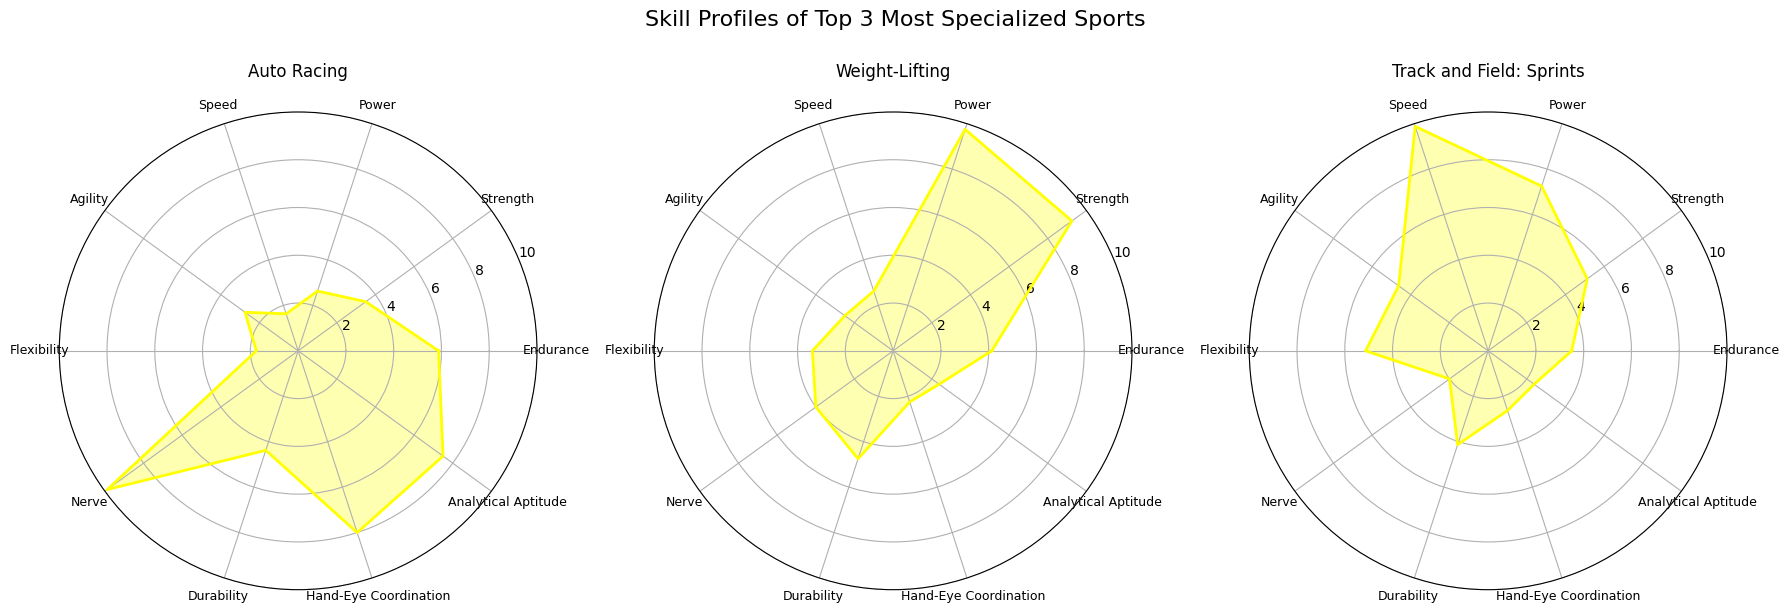

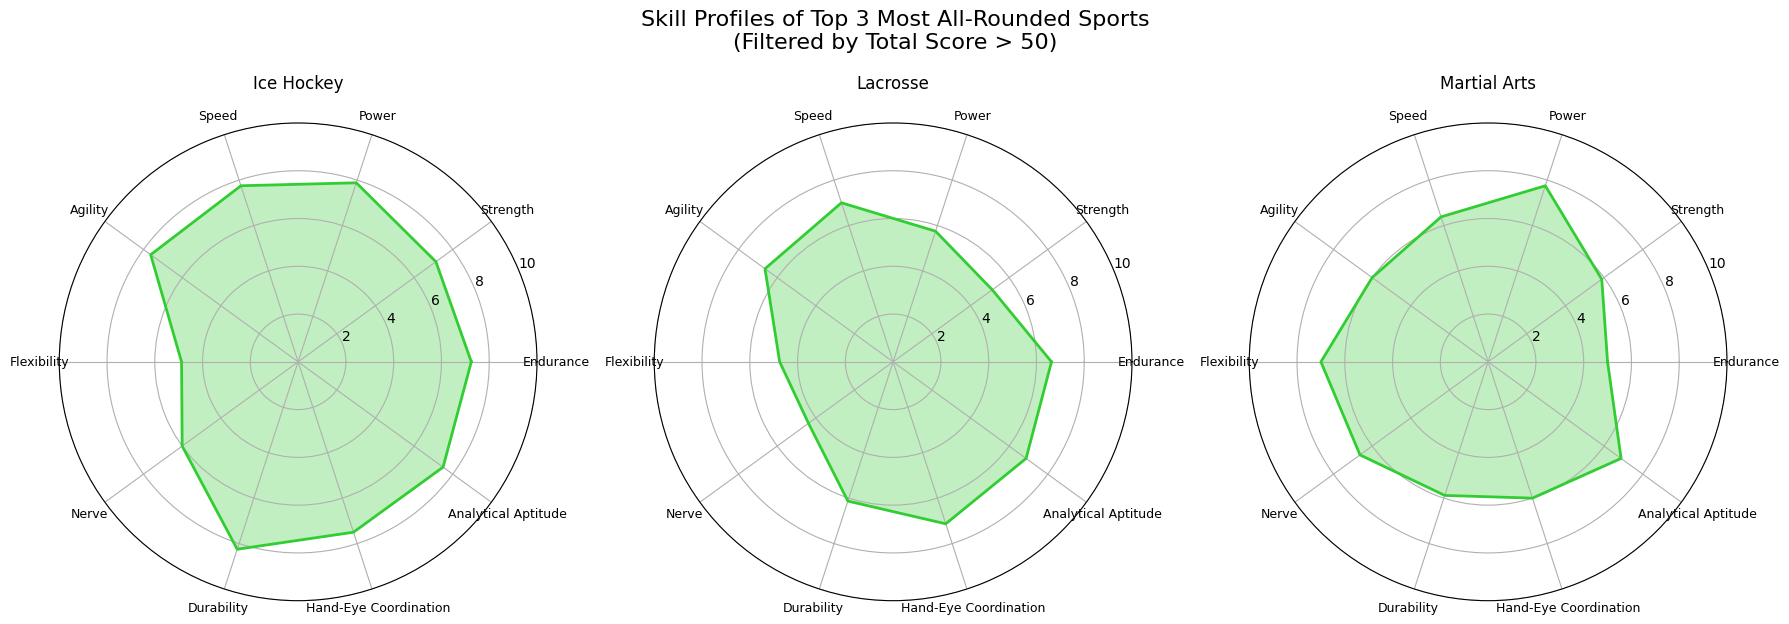

In [12]:
top_specialized_sports = specialized.head(3)['Sport'].values
angles = np.linspace(0, 2 * np.pi, len(skills), endpoint=False).tolist()
angles += angles[:1]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw=dict(polar=True))
fig.suptitle('Skill Profiles of Top 3 Most Specialized Sports', fontsize=16, y=1.02)

for ax, sport in zip(axes, top_specialized_sports):
    values = df[df['Sport'] == sport][skills].values.flatten().tolist()
    values += values[:1]

    ax.plot(angles, values, color='yellow', linewidth=2)
    ax.fill(angles, values, alpha=0.3, color='yellow')
    ax.set_thetagrids(np.degrees(angles[:-1]), skills, fontsize=9)
    ax.set_ylim(0, 10)
    ax.set_title(f'{sport}', fontsize=12, pad=25)
    ax.grid(True)

plt.tight_layout()
plt.show()


min_total_score = 50
qualified_all_rounders = df[df['Total'] > min_total_score].sort_values(by='Skill_STD', ascending=False)
least_specialized_sports = qualified_all_rounders.tail(3)['Sport'].values

angles = np.linspace(0, 2 * np.pi, len(skills), endpoint=False).tolist()
angles += angles[:1]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw=dict(polar=True))
fig.suptitle('Skill Profiles of Top 3 Most All-Rounded Sports\n(Filtered by Total Score > 50)', fontsize=16, y=1.02)

for ax, sport in zip(axes, least_specialized_sports):
    values = df[df['Sport'] == sport][skills].values.flatten().tolist()
    values += values[:1]

    ax.plot(angles, values, color='limegreen', linewidth=2)
    ax.fill(angles, values, alpha=0.3, color='limegreen')
    ax.set_thetagrids(np.degrees(angles[:-1]), skills, fontsize=9)
    ax.set_ylim(0, 10)
    ax.set_title(f'{sport}', fontsize=12, pad=25)
    ax.grid(True)

plt.tight_layout()
plt.show()

This visualization reinforces the conceptual divide between specialized and all-rounded sports based on skill distribution profiles. The top specialized sports—**Auto Racing**, **Weight-Lifting**, and **Track and Field: Sprints**—demonstrate steep imbalances across key skill categories, with dominant peaks in areas like power, speed, or nerve, and marked deficiencies elsewhere. Their elevated standard deviations (avg. STD = 2.69) signal a focused intensity in just one or two domains. By contrast, the most balanced sports—**Ice Hockey**, **Lacrosse** and **Martial Arts**—display flatter, more symmetrical radar plots, indicating versatility across agility, endurance, coordination, and strength, with lower variability (avg. STD = 0.90). By filtering out low-performing but balanced sports (e.g., **Fishing**), the analysis isolates genuinely all-rounded disciplines that combine breadth and competency. These divergent profiles emphasize how sports demand not just physical excellence, but strategically different kinds of it.

## 5. **What Are the Co-Dependency Patterns Among Athletic Skills Across Sports?**

---


This analysis employs network analysis methods to examine the interdependencies and correlations between different athletic skills across sports. The study investigates which skill combinations frequently co-occur at high levels within the same sports (such as the relationship between speed and agility), visualizing these relationships through network graphs to reveal the underlying structure of athletic skill requirements and identify key skill synergies in competitive sports.


=== Skill Communities ===
Module 1: Power, Strength
Module 2: Endurance, Speed
Module 3: Agility, Flexibility
Module 4: Durability, Nerve
Module 5: Analytical Aptitude, Hand-Eye Coordination

=== Skill Centrality Metrics ===
                       Betweenness  Eigenvector    Degree
Durability                0.250000     0.495343  0.666667
Agility                   0.222222     0.385837  0.555556
Speed                     0.138889     0.392734  0.555556
Strength                  0.055556     0.392074  0.444444
Power                     0.027778     0.355978  0.444444
Endurance                 0.000000     0.326517  0.444444
Flexibility               0.000000     0.162361  0.333333
Nerve                     0.000000     0.195214  0.333333
Hand-Eye Coordination     0.000000     0.000010  0.333333
Analytical Aptitude       0.000000     0.000010  0.333333

Network density p-value: 1.0000 (permutation test)


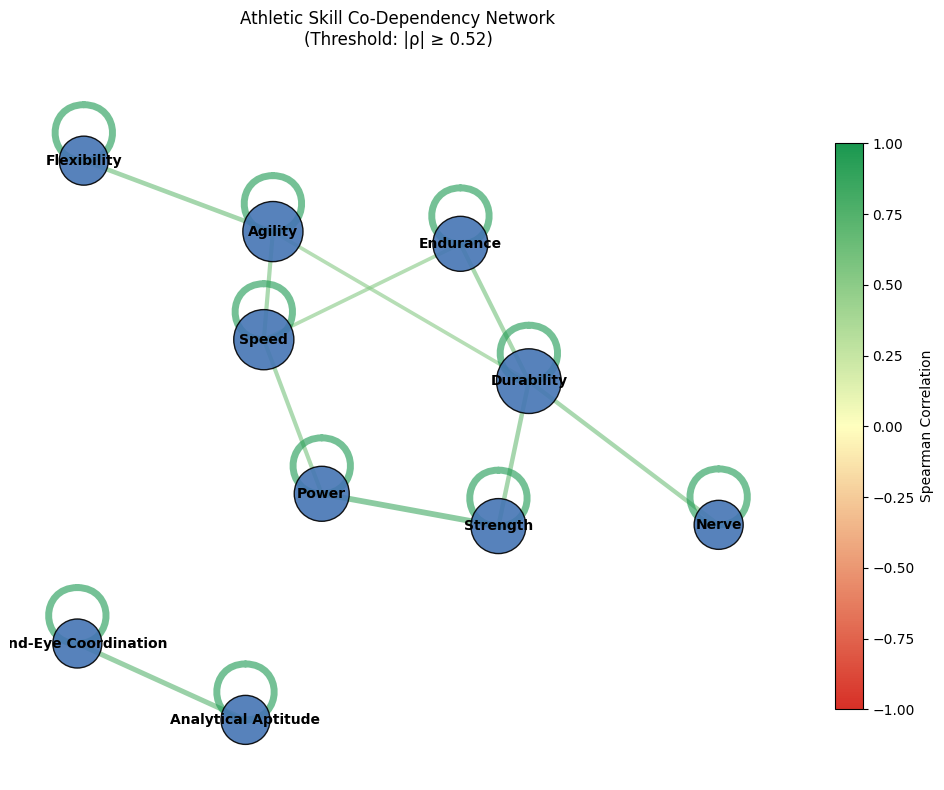

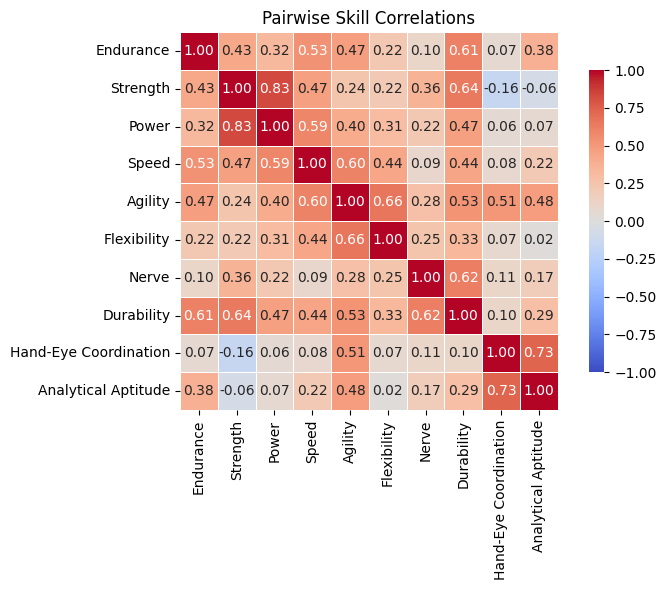

In [13]:
corr_matrix = df[skills].corr(method='spearman')
threshold = np.quantile(corr_matrix.abs().values.flatten(), 0.7)
adj_matrix = corr_matrix.abs() * (corr_matrix.abs() >= threshold)
G = nx.from_pandas_adjacency(adj_matrix)

fig, ax = plt.subplots(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.8, seed=42)
degree_centrality = nx.degree_centrality(G)
node_sizes = [3000 * (degree_centrality[node] ** 0.8) for node in G.nodes()]
edge_weights = [5 * G[u][v]['weight'] for u, v in G.edges()]
edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
cmap = LinearSegmentedColormap.from_list('rd_gn', ['#d73027', '#ffffbf', '#1a9850'])

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='#4575b4', alpha=0.9, edgecolors='black', linewidths=1)
edges = nx.draw_networkx_edges(
    G, pos, width=edge_weights,
    edge_color=edge_colors, edge_cmap=cmap,
    edge_vmin=-1, edge_vmax=1, alpha=0.6, ax=ax
)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', font_family='sans-serif', font_color='black')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=ax, shrink=0.8).set_label('Spearman Correlation', fontsize=10)

plt.title('Athletic Skill Co-Dependency Network\n(Threshold: |ρ| ≥ %.2f)' % threshold, fontsize=12, pad=20)
plt.box(False)
plt.tight_layout()

communities = list(community.greedy_modularity_communities(G, weight='weight'))
print("\n=== Skill Communities ===")
for i, comm in enumerate(communities):
    print(f"Module {i+1}: {', '.join(sorted(comm))}")

centrality = pd.DataFrame({
    'Betweenness': nx.betweenness_centrality(G, weight='weight'),
    'Eigenvector': nx.eigenvector_centrality(G, weight='weight'),
    'Degree': nx.degree_centrality(G)
}, index=skills)

print("\n=== Skill Centrality Metrics ===")
print(centrality.sort_values('Betweenness', ascending=False))

n_permutations = 1000
original_density = nx.density(G)
random_densities = []

for _ in range(n_permutations):
    random_matrix = np.random.permutation(corr_matrix.values.flatten()).reshape(corr_matrix.shape)
    abs_random_matrix = np.abs(random_matrix)
    adj_random_matrix = abs_random_matrix * (abs_random_matrix >= threshold)
    random_adj_df = pd.DataFrame(adj_random_matrix, columns=skills, index=skills)
    random_G = nx.from_pandas_adjacency(random_adj_df)
    random_densities.append(nx.density(random_G))

p_value = (np.sum(np.array(random_densities) >= original_density) + 1) / (n_permutations + 1)
print(f"\nNetwork density p-value: {p_value:.4f} (permutation test)")

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True, fmt=".2f",
    cmap='coolwarm', center=0,
    vmin=-1, vmax=1, square=True,
    linewidths=0.5, cbar_kws={'shrink': 0.8}
)
plt.title('Pairwise Skill Correlations', fontsize=12)
plt.tight_layout()
plt.show()


The network reveals five clear skill communities, such as **Power–Strength** and **Endurance–Speed**, reflecting common athletic pairings. Durability stands out as the most central skill, bridging multiple groups, while Agility and Speed also play key connective roles. In contrast, Hand-Eye Coordination and Analytical Aptitude are peripheral, suggesting specialization rather than broad applicability. The high network density (p = 1.00) highlights strong inter-skill connections across sports.